# Computational Experiments - Data Analysis
Programmer: Andrew Souther <br>
Date: March 2022

This Jupyter notebook contains the code for all the figures and tables we generate in our paper. We also generate a few figures that did not end up in the final draft of the paper. In our paper, we run a series of computational experiments testing the effect of certain parameter changes. This notebook automatically imports those data from the `data_files` directory.

To begin, we import all the packages we need. We use pandas for data manipulation, matplotlib for visualization.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import json
import numpy as np
import math
import csv

We will also define a few helpful functions to make repetitive data tasks a bit cleaner. 

In [2]:
#this function imports an experiment data log file and performs some simple cleaning
def import_and_clean(filepath):
    
    df = pd.read_json(filepath, lines=True)
    
    df["proportion_vacc"] = 1 - (df["unvaccinated"] / df["hub_size"])
    df["proportion_inf"] = (df["recovered"] / df["hub_size"]) 
    df["hub_id"] = df["hub"].astype(str) + df["inst_unique_id"] #generate a unique id for each hub
    
    expanded_df = df["infection_cost"].apply(pd.Series)
    df['infection_cost_lower'] = expanded_df[0]
    df['infection_cost_upper'] = expanded_df[1] 
    
    return df

#this function builds a dataframe of "steady-state" values, averaged for each hub over the last five seasons
def collapse_steady_state(df):
    
    df_last5 = df.query("season>=20")

    #collapse the data to the hub level, averaging over the last 5 seasons
    df_hubs = df_last5[["proportion_inf", 
                          "proportion_vacc", 
                          "homophily", 
                          "hub_density",
                          "infection_cost_lower",
                          "infection_cost_upper",
                          "hub_id"]].groupby(["hub_id"]).mean()
    return df_hubs

# an alternate version of collapse_steady_state() that also collapses treatment IDs
def collapse_steady_state_alt(df):
    
    df_last5 = df.query("season>=20")

    #collapse the data to the hub level, averaging over the last 5 seasons
    df_hubs = df_last5[["proportion_inf", 
                          "proportion_vacc", 
                          "homophily", 
                          "hub_density",
                          "infection_cost_lower",
                          "infection_cost_upper",
                          "treatment_id",
                          "hub_id"]].groupby(["hub_id"]).mean()
    return df_hubs

# this function collapses data to the season level, displays urban & rural vax rates over time, then
# saves the graph as an image
def visualize_seasonal_data(value_df,title_string,image_filepath):

    urban_grouped = value_df.query("hub_density==12").groupby(["season"]).mean()
    rural_grouped = value_df.query("hub_density==8").groupby(["season"]).mean()
    x = urban_grouped.index

    plt.plot(x, urban_grouped["proportion_vacc"], color='#7f6d5f', label='Urban')
    plt.plot(x, rural_grouped["proportion_vacc"], color='#557f2d', label='Rural')
    plt.title(f"Average Regional Vaccination over Time, " + title_string) 
    plt.xlabel("Season")
    plt.ylabel("Vaccination Rate")
    plt.legend(loc="best")
    
    plt.savefig(image_filepath, bbox_inches='tight')
    plt.clf()

# Analysis of Computational Experiments

## Testing Discount Rates

The first experiment we report in the paper is a test of different "discount rates." This is the discount rate that agents use to calculate a weighted average of past infection risks in their home region. 

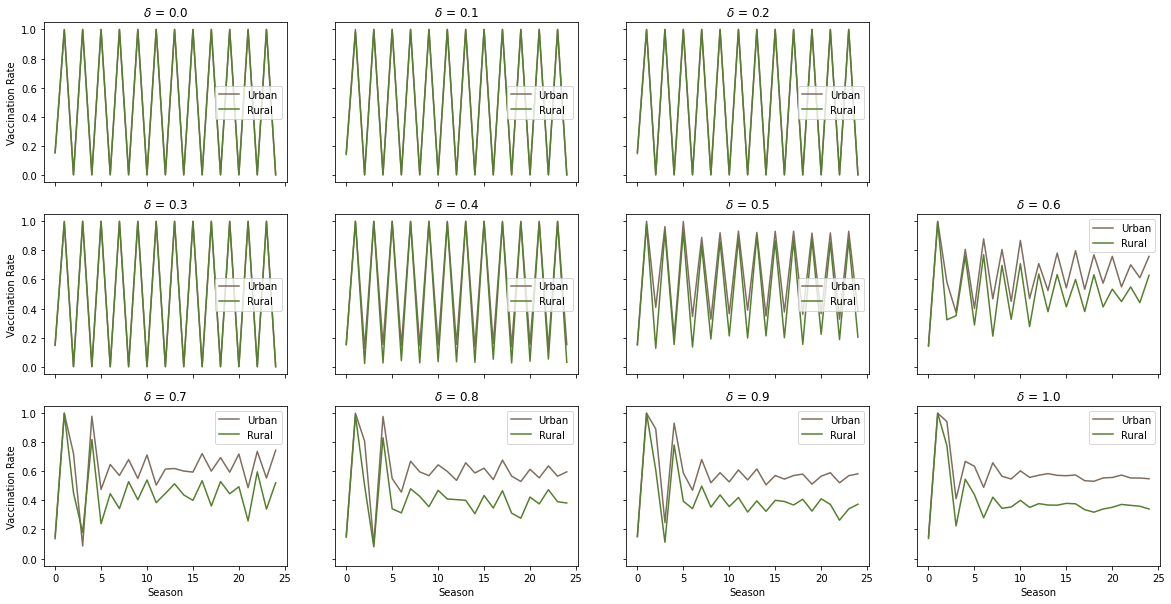

In [3]:
raw_df = import_and_clean(f'data_files/discount_test_data.log') #import the discount test data
discount_factors = raw_df['discount_factor'].unique().tolist() # create a unique list of discount rates from the data


#x = range(25) # every line plot in the grid will have an x-axis of 25 seasons
fig, axes = plt.subplots(nrows=3, ncols=4, figsize = (20,10), sharey=True, sharex=True)

row = 0
column = 0

for discount_factor in discount_factors: # create a line plot for each unique discount rate in the data
    
    # select a subset of the data with the current discount rate
    value_df = raw_df[raw_df["discount_factor"] == discount_factor]
    rounded_value = round(discount_factor,2)
    
    #group the data into rural and urban subsets
    urban_grouped = value_df.query("hub_density==12").groupby(["season"]).mean()
    rural_grouped = value_df.query("hub_density==8").groupby(["season"]).mean()
    x = urban_grouped.index

    #plot average vaccination by season in rural vs. urban regions
    axes[row,column].plot(x, urban_grouped["proportion_vacc"], color='#7f6d5f', label='Urban')
    axes[row,column].plot(x, rural_grouped["proportion_vacc"], color='#557f2d', label='Rural')
    
    #add titles, labels, and legends (depending on the location of the plot in the grid)
    title_string = f"$\delta$ = {rounded_value}"
    axes[row,column].set_title(title_string) 
    axes[row,column].legend(loc="best")
    if column == 0:
        axes[row,column].set_ylabel("Vaccination Rate")    
    if (row == 2): 
        axes[row,column].set_xlabel("Season")
        
        
    column += 1
    if (column == 3 and row == 0) or (column == 4): # this logic creates the missing plot in the top right of the grid
        row += 1 
        column = 0

axes[0,3].set_visible(False) # remove the blank plot from the missing grid spot
plt.savefig('images/discount_test.png', bbox_inches='tight')

## Experiment 1 - Homophily

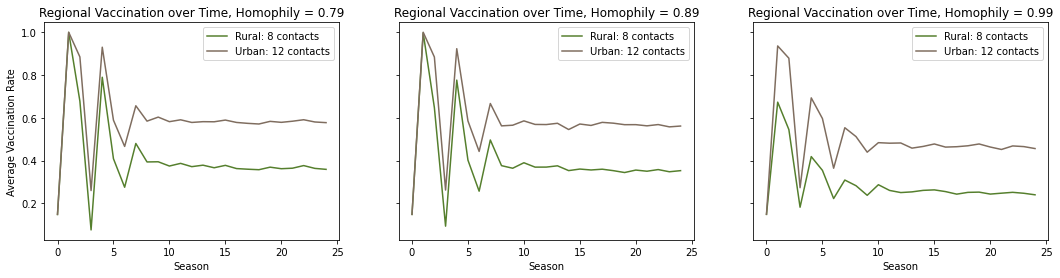

In [4]:
exp1_df = import_and_clean(f'data_files/exp1_data.log')
homophily_list = exp1_df['homophily'].unique().tolist() # get a list of unique homophily values in data

fig, axes = plt.subplots(nrows=1, ncols=len(homophily_list), figsize = (18,4), sharey=True)
for i in range(len(homophily_list)): #iterate through the list of homophily values
    homophily = homophily_list[i]
    
    # subset data, then group into rural and urban averages over time
    value_df = exp1_df[exp1_df["homophily"] == homophily]
    urban_grouped = value_df.query("hub_density==12").groupby(["season"]).mean()
    rural_grouped = value_df.query("hub_density==8").groupby(["season"]).mean()
    x = urban_grouped.index
    
    #plot average vaccination by season in rural vs. urban regions
    axes[i].plot(x, rural_grouped["proportion_vacc"], color='#557f2d', label=f'Rural: 8 contacts')
    axes[i].plot(x, urban_grouped["proportion_vacc"], color='#7f6d5f', label=f'Urban: 12 contacts')
    axes[i].set_title(f"Regional Vaccination over Time, Homophily = {homophily}")
    axes[i].legend(loc="best")
    axes[i].set_xlabel("Season")
    
    if i == 0: #only put y-axis label on the left-most plot
        axes[i].set_ylabel("Average Vaccination Rate")

    if homophily == 0.89 : #0.89 is our "baseline" value for homophily
        baseline_df = value_df # that means we can save this data as a control group for future experiments

plt.savefig('images/exp1_seasonal_fig.png', bbox_inches='tight')

In [5]:
#find average values for each hub over the last five seasons
exp1_hubs = collapse_steady_state(exp1_df)

#clean up some of the variable names for the table
exp1_hubs["Percent Vaccinated"] = exp1_hubs["proportion_vacc"]*100
exp1_hubs["Percent Infected"] = exp1_hubs["proportion_inf"]*100
exp1_hubs = exp1_hubs.rename(columns={"homophily": "Homophily",
                                    "hub_density": "Hub Contact Rate"})

#build table 1
table1 = exp1_hubs.groupby(["Homophily", "Hub Contact Rate"]).agg({"Percent Infected": ['mean', 'std'],
                                                                  "Percent Vaccinated": ['mean', 'std']}).round(2)
#export table1 to csv and display it
table1.to_csv("tables\homophily_exp_table.csv")
table1

Percent Infected       Percent Vaccinated       
                                       mean   std               mean    std
Homophily Hub Contact Rate                                                 
0.79      8                           21.95  5.57              36.54   7.95
          12                          17.06  4.10              58.26   5.51
0.89      8                           22.80  6.16              35.33   8.20
          12                          17.90  4.64              56.38   6.18
0.99      8                           25.02  9.70              24.63  11.50
          12                          21.93  7.38              46.14   9.88

### Plotting Baseline Graphs

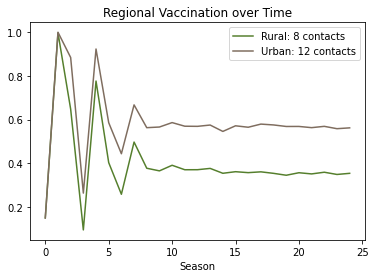

In [6]:
urban_grouped = baseline_df.query("hub_density==12").groupby(["season"]).mean()
rural_grouped = baseline_df.query("hub_density==8").groupby(["season"]).mean()
x = urban_grouped.index
    
plt.plot(x, rural_grouped["proportion_vacc"], color='#557f2d', label=f'Rural: 8 contacts')
plt.plot(x, urban_grouped["proportion_vacc"], color='#7f6d5f', label=f'Urban: 12 contacts')
plt.title("Regional Vaccination over Time")
plt.legend(loc="best")
plt.xlabel("Season")
plt.savefig('images/baseline_vax_rate.png', bbox_inches='tight')

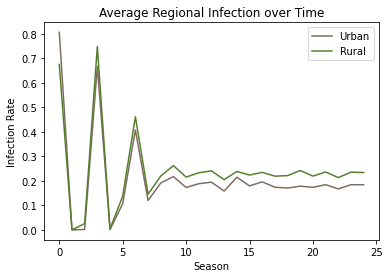

In [7]:
plt.plot(x, urban_grouped["proportion_inf"], color='#7f6d5f', label='Urban')
plt.plot(x, rural_grouped["proportion_inf"], color='#557f2d', label='Rural')
plt.title("Average Regional Infection over Time") 
plt.xlabel("Season")
plt.ylabel("Infection Rate")
plt.legend(loc="best")
plt.savefig('images/baseline_inf_rate.png', bbox_inches='tight')

### Plotting a Histogram of Infection Rates

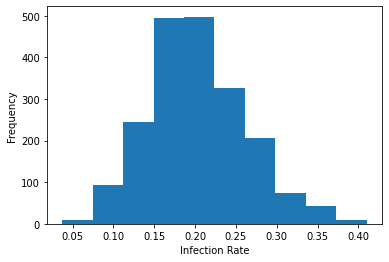

In [8]:
#find average values for each hub over the last five seasons
baseline_hubs = collapse_steady_state(baseline_df)
plt.hist(baseline_hubs['proportion_inf'])
plt.xlabel('Infection Rate')
plt.ylabel('Frequency')
#plt.title('Infection Rates by Region, Averaged over the Last 5 Seasons')
plt.savefig('images/infection_rate_hist.png', bbox_inches='tight')

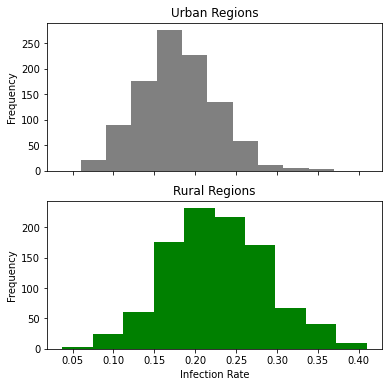

In [9]:
urban_hubs = baseline_hubs.query("hub_density==12")
rural_hubs = baseline_hubs.query("hub_density==8")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (6,6), sharex=True)
axes[0].hist(urban_hubs['proportion_inf'], color = "grey")
axes[0].set_ylabel("Frequency")
axes[0].set_title('Urban Regions')

axes[1].set_title("Rural Regions")
axes[1].hist(rural_hubs['proportion_inf'], color = "green")
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel("Infection Rate")

plt.savefig('images/infection_rate_hist2.png', bbox_inches='tight')

## Experiment 2 - Heterogeneity in Contact Rates

First, we prepare some visualizations to understand the data more deeply.

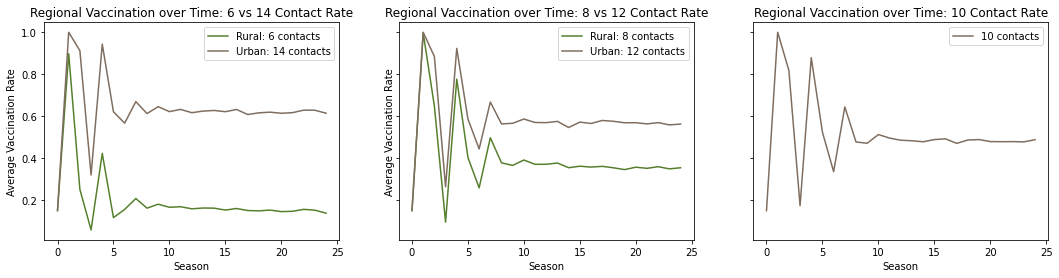

In [10]:
raw_df = import_and_clean(f'data_files/exp2_data.log')
exp2_df = pd.concat([raw_df, baseline_df], axis=0) #concat the exp2 data with the baseline for comparison

density_list = exp2_df['hub_density'].unique().tolist()

# organize data into a dictionary by hub density
grouped_dict = {}
for hub_density in density_list:
    value_df = exp2_df[exp2_df["hub_density"] == hub_density]
    grouped_dict[hub_density] = value_df.groupby(["season"]).mean()


#Build the basic structure of the figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,4), sharey=True)
x = grouped_dict[8].index

# prepare the first two plots, which are going to have separate rural and urban lines
density_list = [(6,14),(8,12)]
for i in range(2):
    first = density_list[i][0]
    second = density_list[i][1]
    axes[i].plot(x, grouped_dict[first]["proportion_vacc"], color='#557f2d', label=f'Rural: {first} contacts')
    axes[i].plot(x, grouped_dict[second]["proportion_vacc"], color='#7f6d5f', label=f'Urban: {second} contacts')
    axes[i].set_title(f"Regional Vaccination over Time: {first} vs {second} Contact Rate")
    axes[i].set_xlabel("Season")
    axes[i].set_ylabel("Average Vaccination Rate")
    axes[i].legend(loc="best")

# prepare the the final plot, where there is no distinction because all hubs have a density of 10
axes[2].plot(x, grouped_dict[10]["proportion_vacc"], color='#7f6d5f', label='10 contacts')
axes[2].set_title("Regional Vaccination over Time: 10 Contact Rate")
axes[2].set_xlabel("Season")
axes[2].legend(loc="best")

plt.savefig('images/exp2_seasonal_fig.png', bbox_inches='tight')
plt.show()

Next, we can produce simple tables on steady state vaccination rates. 

In [11]:
#find average values for each hub over the last five seasons
exp2_hubs = collapse_steady_state(exp2_df)

#clean up some of the variable names for the table
exp2_hubs["Percent Vaccinated"] = exp2_hubs["proportion_vacc"]*100
exp2_hubs["Percent Infected"] = exp2_hubs["proportion_inf"]*100
exp2_hubs = exp2_hubs.rename(columns={"homophily": "Homophily",
                                    "hub_density": "Hub Contact Rate"})

#create a variable for each treatment
exp2_hubs.loc[(exp2_hubs["Hub Contact Rate"]==6) | (exp2_hubs["Hub Contact Rate"]==14), "Treatment"] = "A"
exp2_hubs.loc[(exp2_hubs["Hub Contact Rate"]==8) | (exp2_hubs["Hub Contact Rate"]==12), "Treatment"] = "B"
exp2_hubs.loc[(exp2_hubs["Hub Contact Rate"]==10), "Treatment"] = "C"

#build table 2
table2 = exp2_hubs.groupby(["Treatment", "Hub Contact Rate"]).agg({"Percent Infected": ['mean', 'std'],
                                                                  "Percent Vaccinated": ['mean', 'std','count']}).round(2)
#export table2 to csv and display it
table2.to_csv("tables\contact_rate_exp_table.csv")
table2

Percent Infected       Percent Vaccinated        \
                                       mean   std               mean   std   
Treatment Hub Contact Rate                                                   
A         6                           24.32  6.61              14.64  8.62   
          14                          16.67  4.56              61.98  6.02   
B         8                           22.80  6.16              35.33  8.20   
          12                          17.90  4.64              56.38  6.18   
C         10                          20.05  5.22              47.96  7.22   

                                  
                           count  
Treatment Hub Contact Rate        
A         6                 1000  
          14                1000  
B         8                 1000  
          12                1000  
C         10                2000

## Experiment 3 - Ratio of Cost of Vaccination to Cost of Infection

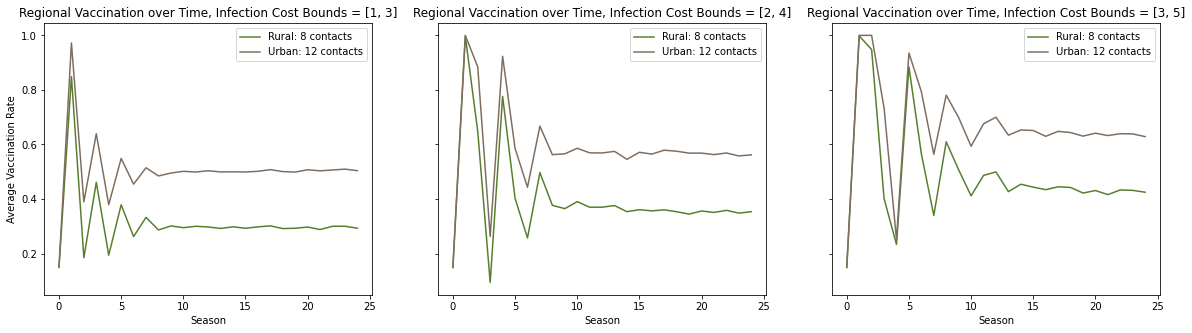

In [12]:
raw_df = import_and_clean(f'data_files/exp3_data.log')
exp3_df = pd.concat([raw_df, baseline_df], axis=0) #concat the exp2 data with the baseline for comparison

lower_bounds = [(i + 1) for i in range(3)]
bounds_list = [[i,i+2] for i in lower_bounds]

#expanded_df = exp3_df["infection_cost"].apply(pd.Series)
#exp3_df['infection_cost_lower'] = expanded_df[0]
#exp3_df['infection_cost_higher'] = expanded_df[1]

fig, axes = plt.subplots(nrows=1, ncols=len(bounds_list), figsize = (20,5), sharey=True)
for i in range(len(bounds_list)):
    bounds = bounds_list[i]
    value_df = exp3_df[(exp3_df["infection_cost_lower"] == bounds[0]) &
                       (exp3_df["infection_cost_upper"] == bounds[1]) ]
    urban_grouped = value_df.query("hub_density==12").groupby(["season"]).mean()
    rural_grouped = value_df.query("hub_density==8").groupby(["season"]).mean()
    x = urban_grouped.index
    
    axes[i].plot(x, rural_grouped["proportion_vacc"], color='#557f2d', label=f'Rural: 8 contacts')
    axes[i].plot(x, urban_grouped["proportion_vacc"], color='#7f6d5f', label=f'Urban: 12 contacts')
    axes[i].set_title(f"Regional Vaccination over Time, Infection Cost Bounds = {bounds}")
    axes[i].legend(loc="best")
    axes[i].set_xlabel("Season")
    
    if i == 0: #only put y-axis label on the left-most plot
        axes[i].set_ylabel("Average Vaccination Rate")
        
plt.savefig('images/exp3_seasonal_fig.png', bbox_inches='tight')
plt.show()

In [13]:
#find average values for each hub over the last five seasons
exp3_hubs = collapse_steady_state(exp3_df)

#clean up some of the variable names for the table
exp3_hubs["Percent Vaccinated"] = exp3_hubs["proportion_vacc"]*100
exp3_hubs["Percent Infected"] = exp3_hubs["proportion_inf"]*100
exp3_hubs["Infection Cost Uniform Dist"] = '[' + exp3_hubs["infection_cost_lower"].apply(str) \
                                               + ','                                              \
                                               + exp3_hubs['infection_cost_upper'].apply(str)     \
                                               + ']'                                     
exp3_hubs = exp3_hubs.rename(columns={"hub_density": "Hub Contact Rate"})


In [14]:
#build table 3
table3 = exp3_hubs.groupby(["Infection Cost Uniform Dist", "Hub Contact Rate"]).agg(
     {"Percent Infected": ['mean', 'std'],
      "Percent Vaccinated": ['mean', 'std','count']}).round(2)

#export table3 to csv and display it
table3.to_csv("tables\infection_cost.csv")
table3

Percent Infected        \
                                                         mean   std   
Infection Cost Uniform Dist Hub Contact Rate                          
[1,3]                       8                           30.79  6.14   
                            12                          25.93  4.76   
[2,4]                       8                           22.80  6.16   
                            12                          17.90  4.64   
[3,5]                       8                           18.48  6.31   
                            12                          14.41  5.32   

                                             Percent Vaccinated               
                                                           mean    std count  
Infection Cost Uniform Dist Hub Contact Rate                                  
[1,3]                       8                             29.55   6.22  1000  
                            12                            50.60   4.62  1000  
[2,4]                       8                             35.33   8.20  1000  
                            12                            56.38   6.18  1000  
[3,5]                       8                             42.73  10.20  1000  
                            12                            63.61   7.87  1000

## Experiment 4 - Heterogeneous Infection Costs

Infection costs differ by urban density within a simulation. 


<ipython-input-15-17a576695357>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[2]["treatment_id"]=2
<ipython-input-15-17a576695357>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[lower_bound]["treatment_id"]=lower_bound
<ipython-input-15-17a576695357>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

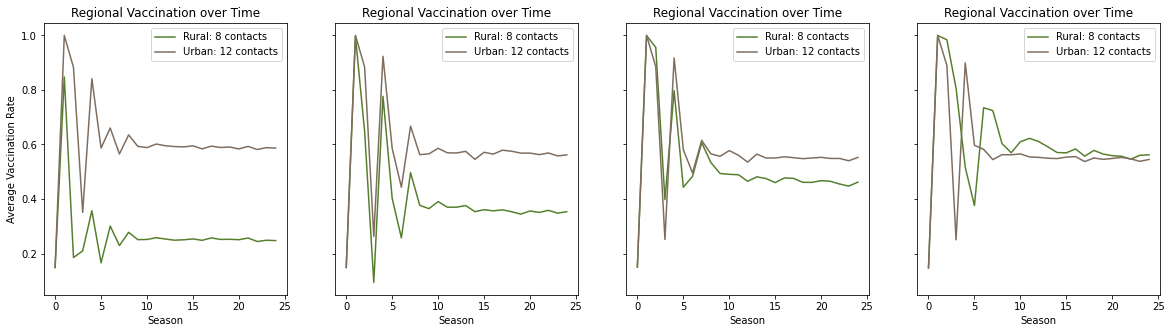

In [15]:
exp4_df = import_and_clean('data_files/exp4_data.log')

df_dict = {}
df_dict[2] = baseline_df
df_dict[2]["treatment_id"]=2

lower_bounds = [1,3,4]
for lower_bound in lower_bounds:
    rural_df = exp4_df[exp4_df["infection_cost_lower"]==lower_bound]
    inst_id_list = rural_df["inst_unique_id"].unique().tolist()
    df_dict[lower_bound] = exp4_df[exp4_df["inst_unique_id"].isin(inst_id_list)]
    df_dict[lower_bound]["treatment_id"]=lower_bound
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (20,5), sharey=True)
for i in range(len(df_dict)):
    lower_bound = i + 1 
    value_df = df_dict[lower_bound]
    
    urban_grouped = value_df.query("hub_density==12").groupby(["season"]).mean()
    rural_grouped = value_df.query("hub_density==8").groupby(["season"]).mean()
    x = urban_grouped.index

    axes[i].plot(x, rural_grouped["proportion_vacc"], color='#557f2d', label=f'Rural: 8 contacts')
    axes[i].plot(x, urban_grouped["proportion_vacc"], color='#7f6d5f', label=f'Urban: 12 contacts')
    axes[i].set_title(f"Regional Vaccination over Time")
    axes[i].legend(loc="best")
    axes[i].set_xlabel("Season")

    if i == 0: #only put y-axis label on the left-most plot
        axes[i].set_ylabel("Average Vaccination Rate")
        
plt.savefig('images/exp4_seasonal_fig.png', bbox_inches='tight')
plt.show()

In [16]:
exp4_df_list = df_dict.values() #convert a dict of dataframes into a list of dataframe
exp4_combined = pd.concat(exp4_df_list, axis=0) #concat all these dfs together
exp4_hubs = collapse_steady_state_alt(exp4_combined) #find average values for each hub over the last five seasons

#clean up some of the variable names for the table
exp4_hubs["Percent Vaccinated"] = exp4_hubs["proportion_vacc"]*100
exp4_hubs["Percent Infected"] = exp4_hubs["proportion_inf"]*100
exp4_hubs = exp4_hubs.rename(columns={"hub_density": "Hub Contact Rate"})

#convert numerical treatment IDs to alphabetical treatment labels
treatment_id_labels = {
    1 : "A",
    2 : "B",
    3 : "C",
    4 : "D"
}
exp4_hubs["Treatment"] = exp4_hubs["treatment_id"].apply(lambda x: treatment_id_labels.get(x)) 


In [17]:
table4 = exp4_hubs.groupby(["Treatment", "Hub Contact Rate"]).agg(
     {"Percent Infected": ['mean', 'std'],
      "Percent Vaccinated": ['mean', 'std','count']}).round(2)

#export table3 to csv and display it
table4.to_csv("tables\het_infection_cost.csv")
table4

Percent Infected       Percent Vaccinated         \
                                       mean   std               mean    std   
Treatment Hub Contact Rate                                                    
A         8                           32.15  6.80              24.95   6.94   
          12                          17.10  4.20              58.65   5.67   
B         8                           22.80  6.16              35.33   8.20   
          12                          17.90  4.64              56.38   6.18   
C         8                           17.06  5.58              45.92   9.63   
          12                          18.66  4.71              54.85   6.42   
D         8                           14.34  5.49              55.66  11.48   
          12                          18.68  4.78              54.62   6.50   

                                  
                           count  
Treatment Hub Contact Rate        
A         8                 1000  
          12                1000  
B         8                 1000  
          12                1000  
C         8                 1000  
          12                1000  
D         8                 1000  
          12                1000

## Experiment 5 - Region Sizes

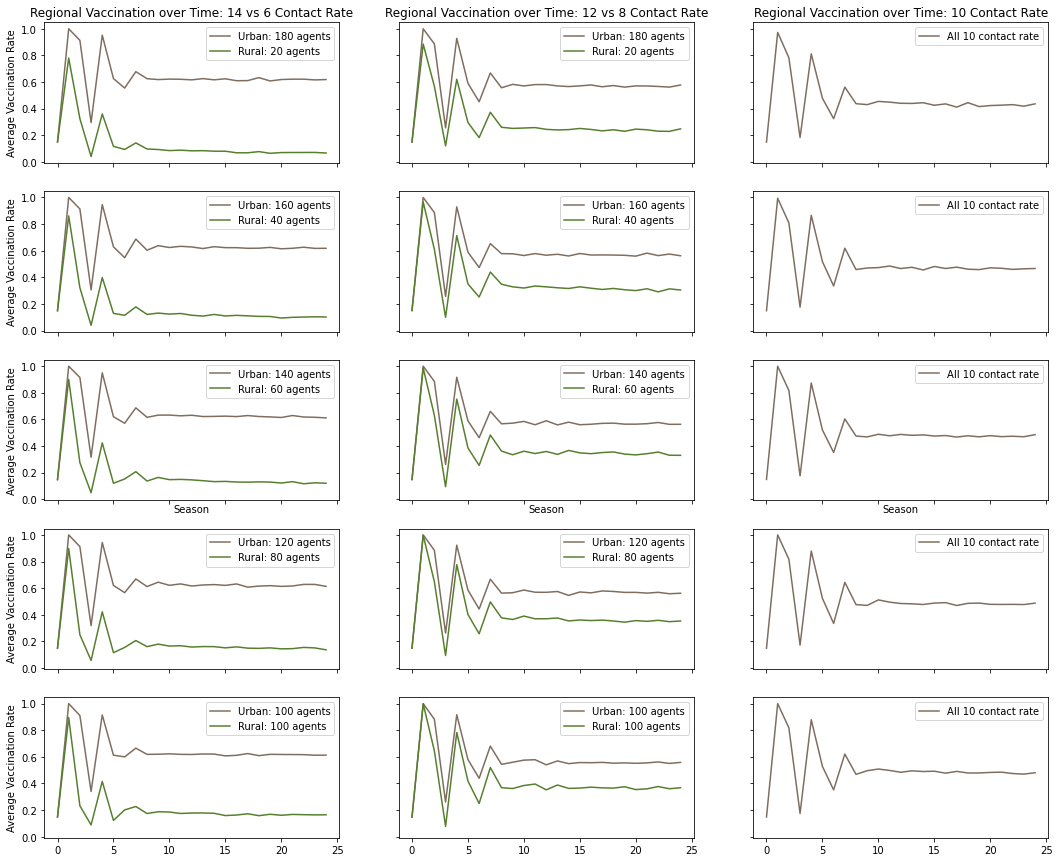

In [18]:
raw_df = import_and_clean('data_files/exp5a_data.log')
exp5_140_df = raw_df[raw_df['hub_size']!=100]
exp5_100_df = raw_df[raw_df['hub_size']==100]

raw_df = import_and_clean('data_files/exp5b_data.log')
exp5_160_df =  raw_df[(raw_df['hub_size']==160) | (raw_df['hub_size']==40)]
exp5_180_df =  raw_df[(raw_df['hub_size']==180) | (raw_df['hub_size']==20)]

x = range(25)
fig, axes = plt.subplots(nrows=5, ncols=3, figsize = (18,15), sharey=True, sharex=True)

#combine data from this experiment with the data from exp 2 as a "baseline"
df_list = [exp5_180_df, exp5_160_df, exp5_140_df,exp2_df,exp5_100_df] 
pop_size_list = [(180,20), (160,40), (140,60), (120,80), (100,100)]
contact_rate_list = [(14,6), (12,8), (10,10)]

#first, we want to loop through every dataframe in the df_list
for i in range(5):
    pop_df = df_list[i]
    urban_pop_size = pop_size_list[i][0]
    rural_pop_size = pop_size_list[i][1]
    
    #then, we want to loop through every possible combination of contact rates in taht df
    for j in range(3):
        
        #find the urban contact rate and the rural contact rate
        urban_cr = contact_rate_list[j][0]
        rural_cr = contact_rate_list[j][1]
        
        #create subsets of the data for urban and rural. Then collapse on season averages
        urban_df = pop_df.query(f"hub_density=={urban_cr}").groupby(["season"]).mean()
        rural_df = pop_df.query(f"hub_density=={rural_cr}").groupby(["season"]).mean()
                
        if urban_cr!=rural_cr: #if urban and rural contact rates are different, plot two lines
            axes[i,j].plot(x, urban_df["proportion_vacc"], color='#7f6d5f', label=f'Urban: {urban_pop_size} agents')
            axes[i,j].plot(x, rural_df["proportion_vacc"], color='#557f2d', label=f'Rural: {rural_pop_size} agents')
            axes[i,j].legend(loc="best")
            if i==0:
                axes[i,j].set_title(f"Regional Vaccination over Time: {urban_cr} vs {rural_cr} Contact Rate")
            
        else: #if the urban and rual contact rates are the same (10), plot only one line
            axes[i,j].plot(x, urban_df["proportion_vacc"], color='#7f6d5f', label='All 10 contact rate')
            axes[i,j].legend(loc="best")
            if i==0: 
                axes[i,j].set_title(f"Regional Vaccination over Time: 10 Contact Rate")
                
        if j==0: #if the plot is on the left column, set a y label
                axes[i,j].set_ylabel("Average Vaccination Rate")
        if i==2: #if the plot is on the bottom row, set an x label
                axes[i,j].set_xlabel("Season")
                
plt.savefig('images/exp5_seasonal_fig.png', bbox_inches='tight')
plt.show()

Make a table!

In [19]:
df_list = [exp5_180_df, exp5_160_df, exp5_140_df, exp2_df, exp5_100_df] 
pop_size_list = [(180,20), (160,40), (140,60), (120,80), (100,100)]
contact_rate_list = [(14,6), (12,8), (10,10)]
roman_numeral_list = ["I", "II", "III", "IV", "V"]

for i in range(len(df_list)):
    df = df_list[i]
    urban_popsize = pop_size_list[i][0]
    collapsed_df = collapse_steady_state(df)
    numeral = roman_numeral_list[i]
    
    collapsed_df["Percent Vaccinated"] = collapsed_df["proportion_vacc"]*100
    collapsed_df["Percent Infected"] = collapsed_df["proportion_inf"]*100
    collapsed_df = collapsed_df.rename(columns={"homophily": "Homophily",
                                    "hub_density": "Hub Contact Rate"})
    
    collapsed_df.loc[(collapsed_df["Hub Contact Rate"]==6) | (collapsed_df["Hub Contact Rate"]==14), "Treatment"] = "A"
    collapsed_df.loc[(collapsed_df["Hub Contact Rate"]==8) | (collapsed_df["Hub Contact Rate"]==12), "Treatment"] = "B"
    collapsed_df.loc[(collapsed_df["Hub Contact Rate"]==10), "Treatment"] = "C"

    table_df = collapsed_df.groupby(["Treatment", "Hub Contact Rate"]).agg({"Percent Vaccinated": ['mean', 'std', 'count']}).round(2)
    table_df = table_df.rename(columns={"Percent Vaccinated": f"Percent Vaccinated (Pop Size {numeral})"})
    
    if i == 0:
        table5a = table_df
        
    elif i > 0:
        table5a = pd.concat([table5a,table_df], axis=1)
        
        
#export table5a to csv and display it
table5a.to_csv("tables\pop_size_vacc_table.csv")
table5a

Percent Vaccinated (Pop Size I)               \
                                                      mean    std count   
Treatment Hub Contact Rate                                                
A         6                                           6.99  10.12  1000   
          14                                         61.92   5.02  1000   
B         8                                          23.91  15.16  1000   
          12                                         56.95   5.28  1000   
C         10                                         42.68  13.74  2000   

                           Percent Vaccinated (Pop Size II)               \
                                                       mean    std count   
Treatment Hub Contact Rate                                                 
A         6                                           10.04   9.43  1000   
          14                                          61.91   5.31  1000   
B         8                                           30.49  11.60  1000   
          12                                          56.84   5.43  1000   
C         10                                          46.61   9.39  2000   

                           Percent Vaccinated (Pop Size III)              \
                                                        mean   std count   
Treatment Hub Contact Rate                                                 
A         6                                            12.33  8.94  1000   
          14                                           61.80  5.57  1000   
B         8                                            33.85  9.65  1000   
          12                                           56.73  5.78  1000   
C         10                                           47.57  7.84  2000   

                           Percent Vaccinated (Pop Size IV)              \
                                                       mean   std count   
Treatment Hub Contact Rate                                                
A         6                                           14.64  8.62  1000   
          14                                          61.98  6.02  1000   
B         8                                           35.33  8.20  1000   
          12                                          56.38  6.18  1000   
C         10                                          47.96  7.22  2000   

                           Percent Vaccinated (Pop Size V)              
                                                      mean   std count  
Treatment Hub Contact Rate                                              
A         6                                          16.45  7.81  1000  
          14                                         61.54  6.69  1000  
B         8                                          36.38  7.42  1000  
          12                                         55.53  6.99  1000  
C         10                                         47.87  7.04  2000

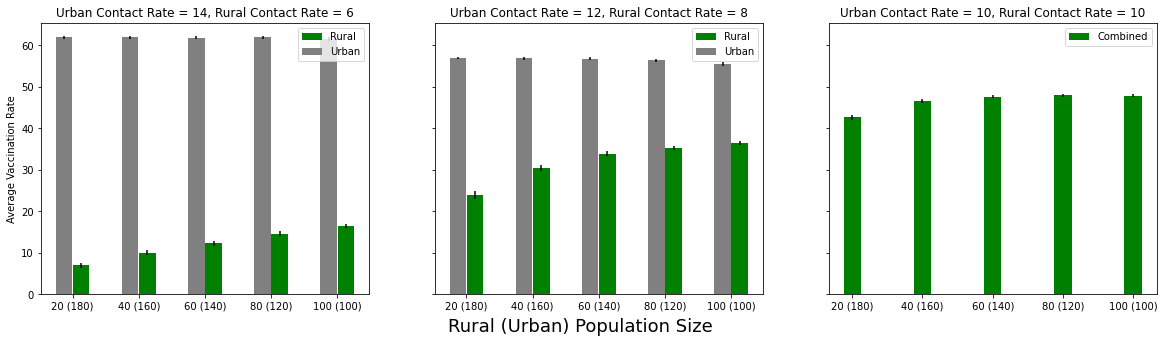

In [20]:
idx = pd.IndexSlice
mean_df = table5a.loc[idx[:,:], idx[:,'mean']]
std_df = table5a.loc[idx[:,:], idx[:,'std']]
count_df = table5a.loc[idx[:,:], idx[:,'count']]
z_critical = stats.norm.ppf(q = 0.975)

index_list = table5a.index.tolist()
raw_labels = [point[0] for point in index_list] #get a list of density treatment values
unique_labels = list(set(raw_labels)) # turn this into a list of unique values 
treatment_labels = sorted(unique_labels) #sort the treatment labels alphabetically

pop_size_list = [(180,20), (160,40), (140,60), (120,80), (100,100)]
contact_rate_list = [(14,6), (12,8), (10,10)]
x_labels = [f"{pair[1]} ({pair[0]})" for pair in pop_size_list]
titles = [f"Urban Contact Rate = {point[0]}, Rural Contact Rate = {point[1]}" for point in contact_rate_list]

treatment_dict = {}
for label in treatment_labels:
    treatment_dict[label] = []

#get a dict of hub densities that match each treatment
for pair in index_list:
    treatment_dict[pair[0]].append(pair[1])
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (20,5), sharey=True, sharex=False)
for i in range(len(treatment_labels)):
    label = treatment_labels[i]
    treatment_list = treatment_dict[label]
    X = np.arange(5) 
    
    if len(treatment_list) > 1:
        #calculate confidence intervals for the rural data in bar graph
        rural_mean = mean_df.loc[label,treatment_list[0]]
        rural_std = std_df.loc[label,treatment_list[0]]
        rural_count = count_df.loc[label,treatment_list[0]]
        rural_error = pd.Series([z_critical * (std/math.sqrt(count)) for std, count in zip(rural_std,rural_count)])
        axes[i].bar(X + .13, rural_mean, color = 'green', yerr=rural_error, width = 0.25, label = "Rural")
        
        #calculate confidence intervals fro urban data in bar graph
        urban_mean = mean_df.loc[label,treatment_list[1]]
        urban_std = std_df.loc[label,treatment_list[1]]
        urban_count = count_df.loc[label,treatment_list[1]]
        urban_error = pd.Series([z_critical * (std/math.sqrt(count)) for std, count in zip(urban_std,urban_count)])
        axes[i].bar(X - .13, urban_mean, color = 'grey', yerr=urban_error, width = 0.25, label = "Urban")
        axes[i].legend(loc="best")
        
    elif len(treatment_list) == 1: 
        #calculate confidence intervals for combined data in bar graph
        combined_mean = mean_df.loc[label,treatment_list[0]]
        combined_std = std_df.loc[label,treatment_list[0]]
        combined_count = count_df.loc[label,treatment_list[0]]
        combined_error = pd.Series([z_critical * (std/math.sqrt(count)) for std, count in zip(combined_std,combined_count)])
        
        axes[i].bar(X, combined_mean, color = 'green', yerr=combined_error,width = 0.25, label = "Combined")
        axes[i].legend(loc="best")
    
    if i == 0:
        axes[i].set_ylabel("Average Vaccination Rate")
        
    axes[i].set_xticks(X)
    axes[i].set_title(titles[i])

    axes[i].set_xticklabels(x_labels)
    
fig.supxlabel('Rural (Urban) Population Size', fontsize = 18)
plt.savefig('images/exp5_bar_graph.png', bbox_inches='tight')